In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import layers, models, optimizers
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def nanscaler(seri):
    temp_list = []
    series_mean = seri.mean()
    series_std = seri.std()
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - series_mean)/series_std)
    return series_mean, series_std, temp_list 

def nanscaler_test(s_mean,s_std,seri):
    temp_list = []
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - s_mean)/s_std)
    return temp_list

In [3]:
df = pd.read_csv('trainMerged.csv')
test_df = pd.read_csv('testMerged.csv')
df['Date'] = pd.to_datetime(df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)
df['IsHoliday'] = df.IsHoliday.astype('int')
test_df['IsHoliday'] = test_df.IsHoliday.astype('int')
MarkDowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in MarkDowns:
    s_mean,s_std, df[i] = nanscaler(df[i])
    test_df[i] = nanscaler_test(s_mean,s_std,test_df[i])

In [4]:
df['Day_of_year'] = [i.dayofyear for i in df.Date]
test_df['Day_of_year'] = [i.dayofyear for i in test_df.Date]
df['Year'] = [i.year for i in df.Date]

In [5]:
doy = []
for i,d in enumerate(df.Day_of_year):
    j = d
    if df['Year'][i] == 2012:
        if d > 60:
            j -= 1
    doy.append(j)
df['Day_of_year'] = doy
df.drop(['Year'],axis=1,inplace=True)
tempp = test_df.Date - pd.to_datetime('2010-01-01')
test_df['total_days'] = [i.total_seconds()/86400 for i in tempp]
tempp = df.Date - pd.to_datetime('2010-01-01')
df['total_days'] = [i.total_seconds()/86400 for i in tempp]
test_df['CPI'] = test_df.groupby('Store')['CPI'].transform(lambda x : x.fillna(x.mean()))
test_df['Unemployment'] = test_df.groupby('Store')['Unemployment'].transform(lambda x : x.fillna(x.mean()))

In [6]:
zero_1_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))


In [14]:
#['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Type', 'Size',
#'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
#'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Day_of_year']
num_cols = ['Size', 'Temperature', 'Fuel_Price','CPI' ,'Unemployment','Day_of_year']
num_df = df[num_cols]
num_df_test = test_df[num_cols]
cat_df = pd.get_dummies(df[['Store','Dept','Type']].astype('str'))
cat_df_test = pd.get_dummies(test_df[['Store','Dept','Type']].astype('str'))
zero_1_scaler.fit(num_df)
num_df = pd.DataFrame(zero_1_scaler.transform(num_df),columns=num_df.columns)
num_df_test = pd.DataFrame(zero_1_scaler.transform(num_df_test),columns=num_df_test.columns)

In [15]:
df_1 = pd.concat([num_df,cat_df,df['Dept'],df['Weekly_Sales']],axis= 1)
test_1 = pd.concat([num_df_test,cat_df_test,test_df['Dept']], axis=1)
test_1['Day_of_year'][test_1.Day_of_year< 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# aa1 = df_1.values
# np.random.shuffle(aa1)
# tr_1 = aa1[:400000,:-1]
# lbl_1 = aa1[:400000,-1]
# val_1 = aa1[400000:,:-1]
# val_lbl_1 = aa1[400000:,-1]
aa = df_1.groupby('Dept')
bb = test_1.groupby('Dept')
departments = df.Dept.unique()
X_train = dict()
X_test = dict()
X_val = dict()
y_train = dict()
y_val = dict()
# for dep in departments:
#     gr_df = aa.get_group(dep).values
#     np.random.shuffle(inds)
    

In [17]:
aa.get_group(1).shape

(6435, 137)

In [18]:
ffd = aa.get_group(1).values
np.random.shuffle(ffd)
X_tr = ffd[:,:-2]
y_tr = ffd[:,-1]
X_v = ffd[-700:,:-2]
y_v = ffd[-700:,-1]

In [19]:
X_tr.shape

(6435, 135)

In [28]:
dep1 = aa.get_group(1)
df.Size.describe()

count    421570.000000
mean     136727.915739
std       60980.583328
min       34875.000000
25%       93638.000000
50%      140167.000000
75%      202505.000000
max      219622.000000
Name: Size, dtype: float64

In [52]:
from sklearn.model_selection import GridSearchCV
regressor = SVR()
params = {'C':[1,100,.01],'gamma':[.001,.01,1]}
gs = GridSearchCV(regressor,param_grid = params, scoring = 'neg_mean_squared_error')

In [53]:
gs.fit(X_tr,y_tr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 100, 0.01], 'gamma': [0.001, 0.01, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [56]:
X_tr.shape

(6435, 54)

In [54]:
mean_absolute_error(y_v, gs.best_estimator_.predict(X_v))

5379.795305754263

In [22]:
pd.Series(y_tr).describe()

count      6435.000000
mean      19213.485088
std       15102.373853
min         711.110000
25%       10423.465000
50%       15314.910000
75%       23135.595000
max      172225.550000
dtype: float64

In [12]:

regressor.fit(X_tr,y_tr)
mean_absolute_error(y_v, regressor.predict(X_v))

8864.322347526593

In [ ]:
regressor.

In [20]:
model1 = models.Sequential()
model1.add(layers.Dense(128,activation='relu',input_shape = (135,)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(1))
model1.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [25]:
# model1.summary()
history =  model1.fit(X_tr,y_tr,epochs= 2000, validation_split=0.05)

Train on 6113 samples, validate on 322 samples
Epoch 1/1000
6113/6113 [==============================] - 1s 185us/step - loss: 11504005.2834 - mean_absolute_error: 1814.5405 - val_loss: 109027429.3665 - val_mean_absolute_error: 4634.7652
Epoch 2/1000
6113/6113 [==============================] - 1s 187us/step - loss: 11693251.0567 - mean_absolute_error: 1799.8034 - val_loss: 96082602.4348 - val_mean_absolute_error: 4372.7625
Epoch 3/1000
6113/6113 [==============================] - 1s 206us/step - loss: 10260099.0251 - mean_absolute_error: 1734.8707 - val_loss: 88434500.7205 - val_mean_absolute_error: 4355.4323
Epoch 4/1000
6113/6113 [==============================] - 1s 180us/step - loss: 9702868.3927 - mean_absolute_error: 1692.3636 - val_loss: 94326049.3913 - val_mean_absolute_error: 4321.3550
Epoch 5/1000
6113/6113 [==============================] - 1s 211us/step - loss: 10668269.7123 - mean_absolute_error: 1721.6148 - val_loss: 91450808.4969 - val_mean_absolute_error: 4363.3800
Epo

6113/6113 [==============================] - 1s 200us/step - loss: 12385217.4393 - mean_absolute_error: 1900.6919 - val_loss: 102978463.8012 - val_mean_absolute_error: 4379.5497
Epoch 44/1000
6113/6113 [==============================] - 1s 198us/step - loss: 11847517.3571 - mean_absolute_error: 1814.0054 - val_loss: 81572859.3292 - val_mean_absolute_error: 4190.5015
Epoch 45/1000
6113/6113 [==============================] - 1s 206us/step - loss: 17078093.0808 - mean_absolute_error: 2116.1134 - val_loss: 83406109.8137 - val_mean_absolute_error: 4254.9990
Epoch 46/1000
6113/6113 [==============================] - 1s 201us/step - loss: 13167943.4036 - mean_absolute_error: 1877.7768 - val_loss: 89201987.4783 - val_mean_absolute_error: 4332.3800
Epoch 47/1000
6113/6113 [==============================] - 1s 198us/step - loss: 11203672.0394 - mean_absolute_error: 1766.6306 - val_loss: 77818899.2795 - val_mean_absolute_error: 4256.3988
Epoch 48/1000
6113/6113 [==============================] -

Epoch 86/1000
6113/6113 [==============================] - 1s 205us/step - loss: 8300275.0133 - mean_absolute_error: 1578.3263 - val_loss: 98023448.2484 - val_mean_absolute_error: 4410.7225
Epoch 87/1000
6113/6113 [==============================] - 1s 196us/step - loss: 10708909.5156 - mean_absolute_error: 1760.5770 - val_loss: 99239635.0807 - val_mean_absolute_error: 4500.7942
Epoch 88/1000
6113/6113 [==============================] - 1s 198us/step - loss: 11673606.5399 - mean_absolute_error: 1832.8745 - val_loss: 103810467.2795 - val_mean_absolute_error: 4454.2411
Epoch 89/1000
6113/6113 [==============================] - 1s 196us/step - loss: 15149807.0688 - mean_absolute_error: 2026.5770 - val_loss: 95015459.3789 - val_mean_absolute_error: 4456.5201
Epoch 90/1000
6113/6113 [==============================] - 1s 195us/step - loss: 16598664.6844 - mean_absolute_error: 2057.5738 - val_loss: 93649807.9006 - val_mean_absolute_error: 4592.2651
Epoch 91/1000
6113/6113 [====================

6113/6113 [==============================] - 1s 206us/step - loss: 10389464.7364 - mean_absolute_error: 1656.6498 - val_loss: 89197825.1925 - val_mean_absolute_error: 4327.3679
Epoch 129/1000
6113/6113 [==============================] - 1s 205us/step - loss: 16286777.1527 - mean_absolute_error: 1898.3605 - val_loss: 134399297.3913 - val_mean_absolute_error: 4991.0052
Epoch 130/1000
6113/6113 [==============================] - 1s 196us/step - loss: 24158325.5743 - mean_absolute_error: 2383.6137 - val_loss: 79747290.6335 - val_mean_absolute_error: 4070.7761
Epoch 131/1000
6113/6113 [==============================] - 1s 193us/step - loss: 11461336.3348 - mean_absolute_error: 1792.7464 - val_loss: 92517990.3602 - val_mean_absolute_error: 4276.7870
Epoch 132/1000
6113/6113 [==============================] - 1s 201us/step - loss: 8263594.8507 - mean_absolute_error: 1593.0960 - val_loss: 76673752.8447 - val_mean_absolute_error: 3968.4656
Epoch 133/1000
6113/6113 [=============================

Epoch 171/1000
6113/6113 [==============================] - 1s 201us/step - loss: 9503949.2090 - mean_absolute_error: 1639.0002 - val_loss: 94952696.8447 - val_mean_absolute_error: 4471.2421
Epoch 172/1000
6113/6113 [==============================] - 1s 195us/step - loss: 9205103.5243 - mean_absolute_error: 1612.2480 - val_loss: 90520287.6025 - val_mean_absolute_error: 4345.8104
Epoch 173/1000
6113/6113 [==============================] - 1s 195us/step - loss: 8150586.2346 - mean_absolute_error: 1528.1261 - val_loss: 110710067.4783 - val_mean_absolute_error: 4536.2591
Epoch 174/1000
6113/6113 [==============================] - 1s 198us/step - loss: 9020875.3652 - mean_absolute_error: 1626.5877 - val_loss: 100057074.4845 - val_mean_absolute_error: 4415.0543
Epoch 175/1000
6113/6113 [==============================] - 1s 200us/step - loss: 8747603.5595 - mean_absolute_error: 1570.6915 - val_loss: 97998798.2609 - val_mean_absolute_error: 4316.7281
Epoch 176/1000
6113/6113 [=================

Epoch 214/1000
6113/6113 [==============================] - 1s 195us/step - loss: 11087958.3559 - mean_absolute_error: 1640.7193 - val_loss: 81728360.5466 - val_mean_absolute_error: 4150.0787
Epoch 215/1000
6113/6113 [==============================] - 1s 201us/step - loss: 7984953.5419 - mean_absolute_error: 1547.8331 - val_loss: 101652347.4286 - val_mean_absolute_error: 4347.6670
Epoch 216/1000
6113/6113 [==============================] - 1s 196us/step - loss: 7419058.6352 - mean_absolute_error: 1503.3231 - val_loss: 87958983.1553 - val_mean_absolute_error: 4310.0694
Epoch 217/1000
6113/6113 [==============================] - 1s 193us/step - loss: 10448364.4726 - mean_absolute_error: 1685.9993 - val_loss: 107001016.1491 - val_mean_absolute_error: 4546.3819
Epoch 218/1000
6113/6113 [==============================] - 1s 203us/step - loss: 11468175.2972 - mean_absolute_error: 1716.1076 - val_loss: 78209658.4348 - val_mean_absolute_error: 3951.6297
Epoch 219/1000
6113/6113 [==============

6113/6113 [==============================] - 1s 219us/step - loss: 16657449.4131 - mean_absolute_error: 1947.9997 - val_loss: 87072639.2050 - val_mean_absolute_error: 4212.8696
Epoch 257/1000
6113/6113 [==============================] - 1s 196us/step - loss: 8996978.4741 - mean_absolute_error: 1607.7397 - val_loss: 82783753.1429 - val_mean_absolute_error: 4098.3553
Epoch 258/1000
6113/6113 [==============================] - 1s 196us/step - loss: 8513753.8736 - mean_absolute_error: 1541.6169 - val_loss: 86368507.1304 - val_mean_absolute_error: 4115.5411
Epoch 259/1000
6113/6113 [==============================] - 1s 201us/step - loss: 7170445.9018 - mean_absolute_error: 1471.4033 - val_loss: 93066175.8012 - val_mean_absolute_error: 4188.2279
Epoch 260/1000
6113/6113 [==============================] - 1s 196us/step - loss: 7106552.2206 - mean_absolute_error: 1458.2049 - val_loss: 90906647.8509 - val_mean_absolute_error: 4267.9450
Epoch 261/1000
6113/6113 [==============================] -

Epoch 299/1000
6113/6113 [==============================] - 1s 196us/step - loss: 10629611.3209 - mean_absolute_error: 1705.9971 - val_loss: 98945294.2112 - val_mean_absolute_error: 4447.4006
Epoch 300/1000
6113/6113 [==============================] - 1s 204us/step - loss: 8160400.3996 - mean_absolute_error: 1516.3251 - val_loss: 94180868.2733 - val_mean_absolute_error: 4223.8963
Epoch 301/1000
6113/6113 [==============================] - 1s 196us/step - loss: 10518622.0486 - mean_absolute_error: 1694.8430 - val_loss: 92082190.3106 - val_mean_absolute_error: 4182.0283
Epoch 302/1000
6113/6113 [==============================] - 1s 198us/step - loss: 8870801.5699 - mean_absolute_error: 1611.9468 - val_loss: 101247837.4161 - val_mean_absolute_error: 4294.2378
Epoch 303/1000
6113/6113 [==============================] - 1s 195us/step - loss: 8238624.2305 - mean_absolute_error: 1555.4270 - val_loss: 97986223.3043 - val_mean_absolute_error: 4454.7845
Epoch 304/1000
6113/6113 [================

6113/6113 [==============================] - 1s 200us/step - loss: 10510301.5767 - mean_absolute_error: 1706.4727 - val_loss: 104713512.4472 - val_mean_absolute_error: 4450.6119
Epoch 342/1000
6113/6113 [==============================] - 1s 196us/step - loss: 13330888.7042 - mean_absolute_error: 1804.2464 - val_loss: 111375188.1739 - val_mean_absolute_error: 4450.4708
Epoch 343/1000
6113/6113 [==============================] - 1s 196us/step - loss: 8489680.2592 - mean_absolute_error: 1554.9385 - val_loss: 109854598.1615 - val_mean_absolute_error: 4334.7791
Epoch 344/1000
6113/6113 [==============================] - 1s 206us/step - loss: 6562624.5968 - mean_absolute_error: 1418.2584 - val_loss: 94036922.6335 - val_mean_absolute_error: 4316.2525
Epoch 345/1000
6113/6113 [==============================] - 1s 197us/step - loss: 6062607.2969 - mean_absolute_error: 1360.1905 - val_loss: 100492406.5590 - val_mean_absolute_error: 4273.6096
Epoch 346/1000
6113/6113 [============================

Epoch 384/1000
6113/6113 [==============================] - 1s 200us/step - loss: 6636948.5257 - mean_absolute_error: 1364.6904 - val_loss: 87798874.8323 - val_mean_absolute_error: 4132.4199
Epoch 385/1000
6113/6113 [==============================] - 1s 200us/step - loss: 6442993.0902 - mean_absolute_error: 1377.4858 - val_loss: 106346308.1739 - val_mean_absolute_error: 4445.4385
Epoch 386/1000
6113/6113 [==============================] - 1s 197us/step - loss: 8498915.9370 - mean_absolute_error: 1515.1538 - val_loss: 97267760.2981 - val_mean_absolute_error: 4325.3219
Epoch 387/1000
6113/6113 [==============================] - 1s 201us/step - loss: 9953992.5145 - mean_absolute_error: 1628.4112 - val_loss: 123081657.8385 - val_mean_absolute_error: 4556.5756
Epoch 388/1000
6113/6113 [==============================] - 1s 198us/step - loss: 16352170.1667 - mean_absolute_error: 1912.6164 - val_loss: 80632128.7950 - val_mean_absolute_error: 3939.0200
Epoch 389/1000
6113/6113 [================

Epoch 427/1000
6113/6113 [==============================] - 1s 196us/step - loss: 9298678.8257 - mean_absolute_error: 1543.8805 - val_loss: 107216952.1491 - val_mean_absolute_error: 4309.2801
Epoch 428/1000
6113/6113 [==============================] - 1s 200us/step - loss: 11003481.9798 - mean_absolute_error: 1712.0787 - val_loss: 91433657.2422 - val_mean_absolute_error: 4256.1957
Epoch 429/1000
6113/6113 [==============================] - 1s 193us/step - loss: 10531892.8832 - mean_absolute_error: 1766.3726 - val_loss: 101940573.0683 - val_mean_absolute_error: 4311.9508
Epoch 430/1000
6113/6113 [==============================] - 1s 196us/step - loss: 8450270.8653 - mean_absolute_error: 1562.1194 - val_loss: 96549126.1615 - val_mean_absolute_error: 4251.5215
Epoch 431/1000
6113/6113 [==============================] - 1s 195us/step - loss: 9756519.1440 - mean_absolute_error: 1550.2712 - val_loss: 110224777.5404 - val_mean_absolute_error: 4303.9265
Epoch 432/1000
6113/6113 [==============

Epoch 470/1000
6113/6113 [==============================] - 1s 198us/step - loss: 7452593.3877 - mean_absolute_error: 1423.7864 - val_loss: 85740819.1801 - val_mean_absolute_error: 4180.9459
Epoch 471/1000
6113/6113 [==============================] - 1s 196us/step - loss: 5706647.7974 - mean_absolute_error: 1291.1999 - val_loss: 111281199.9006 - val_mean_absolute_error: 4399.6968
Epoch 472/1000
6113/6113 [==============================] - 1s 196us/step - loss: 5845926.2419 - mean_absolute_error: 1341.7876 - val_loss: 92394297.6398 - val_mean_absolute_error: 4146.0953
Epoch 473/1000
6113/6113 [==============================] - 1s 196us/step - loss: 5226731.6559 - mean_absolute_error: 1275.4592 - val_loss: 99929149.8137 - val_mean_absolute_error: 4137.2018
Epoch 474/1000
6113/6113 [==============================] - 1s 196us/step - loss: 4742846.7876 - mean_absolute_error: 1227.2374 - val_loss: 96279569.4907 - val_mean_absolute_error: 4141.5376
Epoch 475/1000
6113/6113 [==================

6113/6113 [==============================] - 1s 198us/step - loss: 7731136.9307 - mean_absolute_error: 1439.8220 - val_loss: 95076620.7205 - val_mean_absolute_error: 4164.5904
Epoch 513/1000
6113/6113 [==============================] - 1s 195us/step - loss: 8751001.4589 - mean_absolute_error: 1534.9726 - val_loss: 114586335.2050 - val_mean_absolute_error: 4262.3215
Epoch 514/1000
6113/6113 [==============================] - 1s 194us/step - loss: 7674470.7531 - mean_absolute_error: 1496.5058 - val_loss: 100191408.3975 - val_mean_absolute_error: 4099.2668
Epoch 515/1000
6113/6113 [==============================] - 1s 199us/step - loss: 8575403.5194 - mean_absolute_error: 1499.6698 - val_loss: 97763103.8012 - val_mean_absolute_error: 4178.8283
Epoch 516/1000
6113/6113 [==============================] - 1s 201us/step - loss: 8860848.2618 - mean_absolute_error: 1523.9934 - val_loss: 82217148.2236 - val_mean_absolute_error: 3864.3246
Epoch 517/1000
6113/6113 [==============================] 

6113/6113 [==============================] - 1s 196us/step - loss: 5417605.9964 - mean_absolute_error: 1309.4790 - val_loss: 114580554.4348 - val_mean_absolute_error: 4313.9622
Epoch 555/1000
6113/6113 [==============================] - 1s 198us/step - loss: 9224771.8270 - mean_absolute_error: 1546.6218 - val_loss: 110985190.7578 - val_mean_absolute_error: 4532.0653
Epoch 556/1000
6113/6113 [==============================] - 1s 195us/step - loss: 6552155.1769 - mean_absolute_error: 1386.2058 - val_loss: 114727375.1056 - val_mean_absolute_error: 4402.5920
Epoch 557/1000
6113/6113 [==============================] - 1s 196us/step - loss: 4978739.9918 - mean_absolute_error: 1227.4018 - val_loss: 100188014.1118 - val_mean_absolute_error: 4191.3693
Epoch 558/1000
6113/6113 [==============================] - 1s 201us/step - loss: 9190701.1818 - mean_absolute_error: 1476.5782 - val_loss: 113519479.9503 - val_mean_absolute_error: 4470.3080
Epoch 559/1000
6113/6113 [=============================

Epoch 597/1000
6113/6113 [==============================] - 1s 195us/step - loss: 4865788.2373 - mean_absolute_error: 1222.2733 - val_loss: 98414110.6087 - val_mean_absolute_error: 4144.0041
Epoch 598/1000
6113/6113 [==============================] - 1s 196us/step - loss: 4981449.7047 - mean_absolute_error: 1222.0840 - val_loss: 110343739.8261 - val_mean_absolute_error: 4187.3160
Epoch 599/1000
6113/6113 [==============================] - 1s 200us/step - loss: 5277092.9368 - mean_absolute_error: 1221.4793 - val_loss: 99519533.9130 - val_mean_absolute_error: 4232.9294
Epoch 600/1000
6113/6113 [==============================] - 1s 197us/step - loss: 5777070.1255 - mean_absolute_error: 1313.0607 - val_loss: 100039735.8509 - val_mean_absolute_error: 4249.0918
Epoch 601/1000
6113/6113 [==============================] - 1s 195us/step - loss: 7312353.3364 - mean_absolute_error: 1435.8600 - val_loss: 114423380.4720 - val_mean_absolute_error: 4502.5194
Epoch 602/1000
6113/6113 [================

Epoch 640/1000
6113/6113 [==============================] - 1s 196us/step - loss: 8802012.4212 - mean_absolute_error: 1502.8285 - val_loss: 106375259.0311 - val_mean_absolute_error: 4282.5188
Epoch 641/1000
6113/6113 [==============================] - 1s 196us/step - loss: 5138121.8153 - mean_absolute_error: 1235.3127 - val_loss: 94471076.1739 - val_mean_absolute_error: 4029.8072
Epoch 642/1000
6113/6113 [==============================] - 1s 205us/step - loss: 4999158.4685 - mean_absolute_error: 1191.8990 - val_loss: 95313859.8758 - val_mean_absolute_error: 4186.6804
Epoch 643/1000
6113/6113 [==============================] - 1s 195us/step - loss: 5438394.4119 - mean_absolute_error: 1222.1091 - val_loss: 105677221.4658 - val_mean_absolute_error: 4373.7535
Epoch 644/1000
6113/6113 [==============================] - 1s 198us/step - loss: 4720712.7654 - mean_absolute_error: 1137.5166 - val_loss: 102044363.5280 - val_mean_absolute_error: 4355.5554
Epoch 645/1000
6113/6113 [================

6113/6113 [==============================] - 1s 199us/step - loss: 4024674.2884 - mean_absolute_error: 1110.2717 - val_loss: 94375960.5466 - val_mean_absolute_error: 4204.6020
Epoch 683/1000
6113/6113 [==============================] - 1s 201us/step - loss: 4827504.2518 - mean_absolute_error: 1194.7311 - val_loss: 111965600.1988 - val_mean_absolute_error: 4207.9169
Epoch 684/1000
6113/6113 [==============================] - 1s 198us/step - loss: 14689689.5399 - mean_absolute_error: 1781.3348 - val_loss: 121231308.6211 - val_mean_absolute_error: 4743.4511
Epoch 685/1000
6113/6113 [==============================] - 1s 198us/step - loss: 16370641.5019 - mean_absolute_error: 1870.6752 - val_loss: 107617259.1304 - val_mean_absolute_error: 4406.1846
Epoch 686/1000
6113/6113 [==============================] - 1s 193us/step - loss: 8440327.3296 - mean_absolute_error: 1500.6549 - val_loss: 107742530.1863 - val_mean_absolute_error: 4268.0008
Epoch 687/1000
6113/6113 [============================

Epoch 725/1000
6113/6113 [==============================] - 1s 200us/step - loss: 10406817.8895 - mean_absolute_error: 1706.7340 - val_loss: 94164818.1863 - val_mean_absolute_error: 4148.4028
Epoch 726/1000
6113/6113 [==============================] - 1s 197us/step - loss: 6153841.5397 - mean_absolute_error: 1345.4990 - val_loss: 109067829.8634 - val_mean_absolute_error: 4343.3798
Epoch 727/1000
6113/6113 [==============================] - 1s 195us/step - loss: 6099872.1468 - mean_absolute_error: 1326.8899 - val_loss: 119299023.3540 - val_mean_absolute_error: 4566.5796
Epoch 728/1000
6113/6113 [==============================] - 1s 198us/step - loss: 7912998.5345 - mean_absolute_error: 1437.2578 - val_loss: 116790856.5466 - val_mean_absolute_error: 4285.6959
Epoch 729/1000
6113/6113 [==============================] - 1s 198us/step - loss: 5731109.6006 - mean_absolute_error: 1264.6855 - val_loss: 93654145.1925 - val_mean_absolute_error: 4133.5806
Epoch 730/1000
6113/6113 [===============

Epoch 768/1000
6113/6113 [==============================] - 1s 196us/step - loss: 3707375.5111 - mean_absolute_error: 1060.2304 - val_loss: 97377770.1366 - val_mean_absolute_error: 3995.7814
Epoch 769/1000
6113/6113 [==============================] - 1s 195us/step - loss: 3388549.6704 - mean_absolute_error: 1028.3005 - val_loss: 99995856.7950 - val_mean_absolute_error: 4126.0309
Epoch 770/1000
6113/6113 [==============================] - 1s 197us/step - loss: 2688795.3229 - mean_absolute_error: 967.5369 - val_loss: 100489119.3043 - val_mean_absolute_error: 4083.7514
Epoch 771/1000
6113/6113 [==============================] - 1s 198us/step - loss: 3202039.4186 - mean_absolute_error: 987.2074 - val_loss: 99036889.0932 - val_mean_absolute_error: 4042.2316
Epoch 772/1000
6113/6113 [==============================] - 1s 198us/step - loss: 4533484.4854 - mean_absolute_error: 1166.9507 - val_loss: 88957635.6770 - val_mean_absolute_error: 4184.4568
Epoch 773/1000
6113/6113 [====================

6113/6113 [==============================] - 1s 198us/step - loss: 5025662.9395 - mean_absolute_error: 1183.3766 - val_loss: 92903088.4969 - val_mean_absolute_error: 4049.9943
Epoch 811/1000
6113/6113 [==============================] - 1s 196us/step - loss: 3272861.3609 - mean_absolute_error: 1063.5329 - val_loss: 89945851.8261 - val_mean_absolute_error: 3901.5296
Epoch 812/1000
6113/6113 [==============================] - 1s 196us/step - loss: 4463671.2207 - mean_absolute_error: 1132.0365 - val_loss: 83943787.7267 - val_mean_absolute_error: 4264.6410
Epoch 813/1000
6113/6113 [==============================] - 1s 200us/step - loss: 10662771.7460 - mean_absolute_error: 1544.8550 - val_loss: 91662522.7329 - val_mean_absolute_error: 4456.4126
Epoch 814/1000
6113/6113 [==============================] - 1s 195us/step - loss: 17265627.5195 - mean_absolute_error: 1982.6547 - val_loss: 111242027.4286 - val_mean_absolute_error: 4545.9578
Epoch 815/1000
6113/6113 [==============================]

Epoch 853/1000
6113/6113 [==============================] - 1s 196us/step - loss: 2512431.2351 - mean_absolute_error: 943.0633 - val_loss: 95389276.1242 - val_mean_absolute_error: 4080.3694
Epoch 854/1000
6113/6113 [==============================] - 1s 195us/step - loss: 2359756.1723 - mean_absolute_error: 898.7560 - val_loss: 102259914.9317 - val_mean_absolute_error: 4128.7932
Epoch 855/1000
6113/6113 [==============================] - 1s 203us/step - loss: 2677646.8301 - mean_absolute_error: 926.8969 - val_loss: 91703074.5839 - val_mean_absolute_error: 4012.9344
Epoch 856/1000
6113/6113 [==============================] - 1s 200us/step - loss: 5751940.4049 - mean_absolute_error: 1167.7552 - val_loss: 105965844.5714 - val_mean_absolute_error: 4501.8572
Epoch 857/1000
6113/6113 [==============================] - 1s 198us/step - loss: 8696061.9277 - mean_absolute_error: 1479.9517 - val_loss: 113995964.8199 - val_mean_absolute_error: 4497.7096
Epoch 858/1000
6113/6113 [===================

Epoch 896/1000
6113/6113 [==============================] - 1s 208us/step - loss: 3853093.5948 - mean_absolute_error: 1057.6254 - val_loss: 115008492.6211 - val_mean_absolute_error: 4347.1325
Epoch 897/1000
6113/6113 [==============================] - 1s 202us/step - loss: 4349093.9345 - mean_absolute_error: 1141.9728 - val_loss: 111416693.2671 - val_mean_absolute_error: 4368.2582
Epoch 898/1000
6113/6113 [==============================] - 1s 194us/step - loss: 7420452.3541 - mean_absolute_error: 1376.0720 - val_loss: 115697189.8634 - val_mean_absolute_error: 4312.4469
Epoch 899/1000
6113/6113 [==============================] - 1s 195us/step - loss: 5591716.1440 - mean_absolute_error: 1210.7391 - val_loss: 107543899.7267 - val_mean_absolute_error: 4373.7496
Epoch 900/1000
6113/6113 [==============================] - 1s 193us/step - loss: 2985891.7840 - mean_absolute_error: 979.9835 - val_loss: 109849110.2609 - val_mean_absolute_error: 4215.4739
Epoch 901/1000
6113/6113 [===============

6113/6113 [==============================] - 1s 202us/step - loss: 3697614.7193 - mean_absolute_error: 1003.6645 - val_loss: 96930982.5590 - val_mean_absolute_error: 4032.8682
Epoch 939/1000
6113/6113 [==============================] - ETA: 0s - loss: 4093356.4756 - mean_absolute_error: 1107.81 - 1s 197us/step - loss: 4092745.9535 - mean_absolute_error: 1107.7280 - val_loss: 108572188.4224 - val_mean_absolute_error: 4132.7319
Epoch 940/1000
6113/6113 [==============================] - 1s 198us/step - loss: 5456480.2744 - mean_absolute_error: 1229.5944 - val_loss: 110024142.0124 - val_mean_absolute_error: 4266.9480
Epoch 941/1000
6113/6113 [==============================] - 1s 195us/step - loss: 5500676.5665 - mean_absolute_error: 1194.1612 - val_loss: 121262457.5404 - val_mean_absolute_error: 4452.0666
Epoch 942/1000
6113/6113 [==============================] - 1s 200us/step - loss: 9941834.9736 - mean_absolute_error: 1543.5745 - val_loss: 118786730.3354 - val_mean_absolute_error: 4451

6113/6113 [==============================] - 1s 203us/step - loss: 3954206.3838 - mean_absolute_error: 1120.1662 - val_loss: 100162611.0807 - val_mean_absolute_error: 4260.7776
Epoch 981/1000
6113/6113 [==============================] - 1s 198us/step - loss: 11784041.1403 - mean_absolute_error: 1614.9563 - val_loss: 100927961.6398 - val_mean_absolute_error: 4215.5394
Epoch 982/1000
6113/6113 [==============================] - 1s 196us/step - loss: 9909478.1937 - mean_absolute_error: 1589.5919 - val_loss: 94474670.0124 - val_mean_absolute_error: 4230.5757
Epoch 983/1000
6113/6113 [==============================] - 1s 198us/step - loss: 6853031.0058 - mean_absolute_error: 1356.3236 - val_loss: 105667789.2174 - val_mean_absolute_error: 4311.5709
Epoch 984/1000
6113/6113 [==============================] - 1s 195us/step - loss: 6706489.0104 - mean_absolute_error: 1263.8484 - val_loss: 102600408.1491 - val_mean_absolute_error: 4114.8193
Epoch 985/1000
6113/6113 [=============================

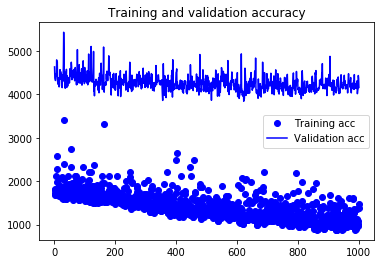

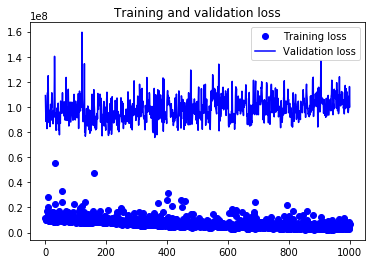

In [26]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
test_arr = test_1.values
test_arr = test_arr[:,:-1]
test_arr.shape
pred = model1.predict(test_arr)

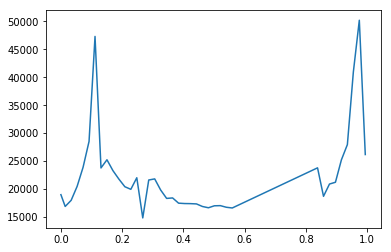

In [47]:
pred = model1.predict(test_arr)
test_dep1_st_1 = test_1[test_1.Store_1 == 1]
test_dep1_st_1 = test_dep1_st_1[test_dep1_st_1.Dept == 1]
pred = pd.Series(pred[:,0])
pred_1_1 = pred.iloc[test_dep1_st_1.index]
test_dep1_st_1['Weekly_Sales'] = pred_1_1
test_dep1_st_1.sort_values('Day_of_year', inplace = True)
plt.plot(test_dep1_st_1.Day_of_year,test_dep1_st_1.Weekly_Sales)

In [89]:
# grp_dep_doy = dict()
# for i, j in aa:
#     grp_dep_doy[i] = j.groupby('Day_of_year')['Weekly_Sales'].mean()
# grp_dep_doy = pd.DataFrame(grp_dep_doy)
# grp_dep_doy.sort_index(inplace=True)
# grp_dep_doy.fillna(0 ,inplace= True)

In [58]:
# def get_sales_mean(doy, dep):
#     f = interp1d(grp_dep_doy.index, grp_dep_doy[dep])
#     return f(doy)

In [90]:
# tes_mean_sales = []
# for dep, doy in zip(test_1.Dept, test_1.Day_of_year):
#     tes_mean_sales.append(get_sales_mean(doy,dep))

In [91]:
# test_1['Mean_Sales'] = tes_mean_sales
# test_1['Mean_Sales'].isnull().sum()

0

In [95]:
# tr_mean_sales = []
# for dep, doy in zip(df_1.Dept, df_1.Day_of_year):
#     tr_mean_sales.append(grp_dep_doy[dep][doy])
# df_1['Mean_Sales'] = tr_mean_sales

In [ ]:
# stores = df.Store.unique()
# dept_no = 7
# for store_no in stores:
#     bb = aa.get_group(store_no)
#     bb = bb[bb.Dept==dept_no]
#     bb.index = range(len(bb))
#     bb = np.split(bb, bb[bb.round_days.diff()<0].index, axis = 0)
#     for i in bb:
#         plt.plot(i.round_days,i.Weekly_Sales/(i.Weekly_Sales.mean()))